In [1]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files


In [2]:
# Mount Google Drive to save/load models
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Install kaggle API and set it up for dataset download
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # Update path if needed
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d abhaysharma38/indian-folk-art-gallery-high-resolution-images

# Unzip the dataset
!unzip -q indian-folk-art-gallery-high-resolution-images.zip -d /content/folk-art-dataset-main/


mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images
License(s): CC-BY-NC-SA-4.0
indian-folk-art-gallery-high-resolution-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Path to dataset
image_dir = '/content/folk-art-dataset-main/folk-art-dataset-main'
IMG_SIZE = 128  # NASNetMobile input size
images = []
image_labels = []

# Load image data
def load_images(image_dir, labels):
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                try:
                    # Load and preprocess images
                    image = Image.open(img_path).convert('RGB')
                    image = image.resize((IMG_SIZE, IMG_SIZE))
                    images.append(np.array(image))
                    image_labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Get labels and load data
labels = os.listdir(image_dir)
load_images(image_dir, labels)

# Convert lists to numpy arrays
images = np.array(images, dtype='float32') / 255.0  # Normalize to [0, 1]
label_to_num = {label: idx for idx, label in enumerate(np.unique(image_labels))}
numerical_labels = np.array([label_to_num[label] for label in image_labels])
y_categorical = to_categorical(numerical_labels, num_classes=len(label_to_num))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, y_categorical, test_size=0.2, random_state=42)


In [8]:
# Load NASNetMobile pre-trained model
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the pre-trained layers

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_to_num), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


19993432/19993432 [==============================] - 0s 0us/step


In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# Save the trained model
model_path = '/content/drive/MyDrive/nasnet_folk_art_model.h5'
model.save(model_path)


Epoch 1/50
808/808 [==============================] - 93s 100ms/step - loss: 2.6037 - accuracy: 0.2776 - val_loss: 1.9568 - val_accuracy: 0.4595
Epoch 2/50
808/808 [==============================] - 76s 94ms/step - loss: 2.0691 - accuracy: 0.4126 - val_loss: 1.7877 - val_accuracy: 0.5060
Epoch 3/50
808/808 [==============================] - 77s 95ms/step - loss: 1.8695 - accuracy: 0.4614 - val_loss: 1.6371 - val_accuracy: 0.5358
Epoch 4/50
808/808 [==============================] - 77s 95ms/step - loss: 1.7483 - accuracy: 0.4956 - val_loss: 1.5629 - val_accuracy: 0.5575
Epoch 5/50
808/808 [==============================] - 76s 95ms/step - loss: 1.6533 - accuracy: 0.5202 - val_loss: 1.5071 - val_accuracy: 0.5822
Epoch 6/50
808/808 [==============================] - 77s 95ms/step - loss: 1.5738 - accuracy: 0.5393 - val_loss: 1.4642 - val_accuracy: 0.5894
Epoch 7/50
808/808 [==============================] - 76s 94ms/step - loss: 1.5000 - accuracy: 0.5557 - val_loss: 1.4199 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


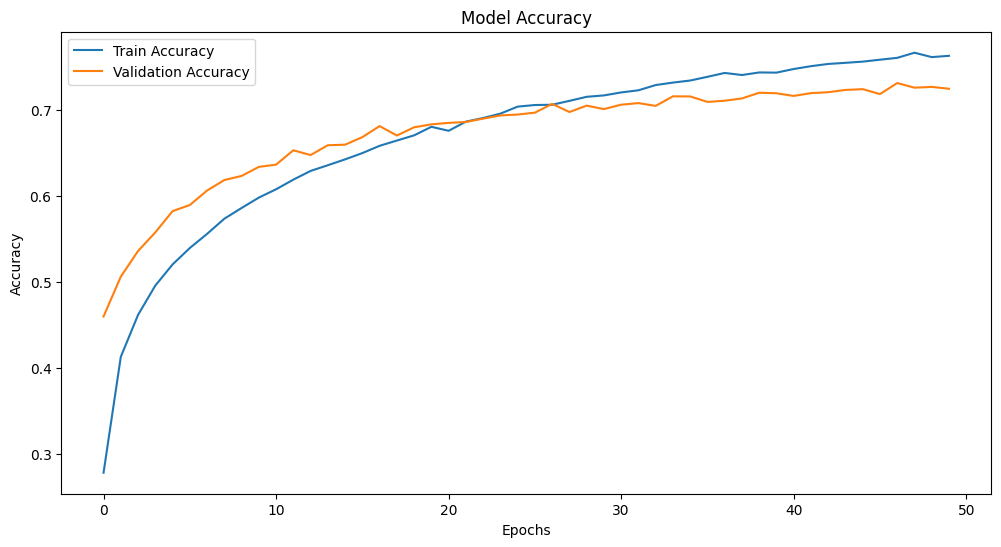

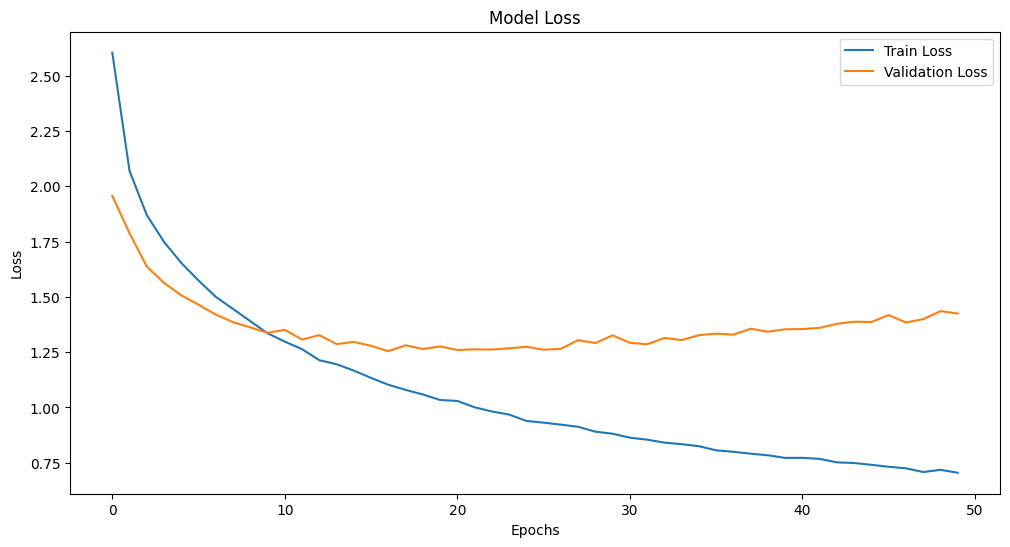

In [10]:
# Function to plot accuracy and loss
def plot_accuracy_and_loss(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot accuracy and loss
plot_accuracy_and_loss(history)


Saving 34.jpg to 34.jpg
1/1 [==============================] - 4s 4s/step


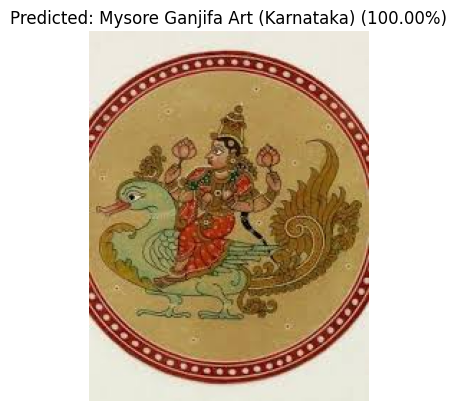

In [12]:
# Function to test the model with uploaded images
def predict_image(model, class_labels):
    # Upload image
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_path = filename
        image = Image.open(img_path).convert('RGB')
        image = image.resize((IMG_SIZE, IMG_SIZE))
        image = np.array(image) / 255.0  # Normalize
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Predict class
        prediction = model.predict(image)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        # Display results
        plt.imshow(Image.open(img_path))
        plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()

# Map numerical labels back to class labels
class_labels = [
    'Aipan Art (Uttarakhand)', 'Assamese Miniature Painting (Assam)', 'Basholi Painting (Jammu and Kashmir)',
    'Bhil Painting (Madhya Pradesh)', 'Chamba Rumal (Himachal Pradesh)', 'Cheriyal Scroll Painting (Telangana)',
    'Dokra Art (West Bengal)', 'Gond Painting (Madhya Pradesh)', 'Kalamkari Painting (Andhra Pradesh and Telangana)',
    'Kalighat Painting (West Bengal)', 'Kangra Painting (Himachal Pradesh)', 'Kerala Mural Painting (Kerala)',
    'Kondapalli Bommallu (Andhra Pradesh)', 'Kutch Lippan Art (Gujarat)', 'Leather Puppet Art (Andhra Pradesh)',
    'Madhubani Painting (Bihar)', 'Mandala Art', 'Mandana Art (Rajasthan)', 'Mata Ni Pachedi (Gujarat)',
    'Meenakari Painting (Rajasthan)', 'Mughal Paintings', 'Mysore Ganjifa Art (Karnataka)',
    'Pattachitra Painting (Odisha and Bengal)', 'Patua Painting (West Bengal)', 'Pichwai Painting (Rajasthan)',
    'Rajasthani Miniature Painting (Rajasthan)', 'Rogan Art from Kutch (Gujarat)', 'Sohrai Art (Jharkhand)',
    'Tikuli Art (Bihar)', 'Warli Folk Painting (Maharashtra)'
]
predict_image(model, class_labels)
